In [125]:
%matplotlib inline
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from core import *

In [80]:
sp = get_sp()
rets=sp.pct_change()
df=pd.DataFrame()
df['X1']=rets
df['X2']=get_bond_time_series()
df['Y']=rets.shift(1)
df['Ybar']=df.Y/df.Y.abs()
df=df.dropna()

In [103]:
s=[]
for i in df.Y:
    s.append(1 if i>0 else 0)
df['Y2']=pd.Series(s,index=df.index)

In [148]:
num_round=2
lgb.cv(param, train_data, num_round, nfold=5)

{'auc-mean': [0.5196829291716687, 0.4894510604241697],
 'auc-stdv': [0.027771118781961566, 0.03404775939271281]}

In [105]:
x=df[['X1','X2']].values
y=df.Y2.values

In [149]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3333, random_state = 0)

In [150]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [151]:
d_train = lgb.Dataset(x_train, label=y_train)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)

In [152]:
y_pred=clf.predict(x_test)

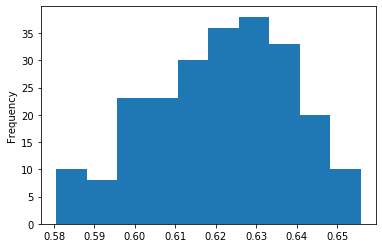

In [153]:
pd.Series(y_pred).plot(kind='hist')

In [154]:
y_pred_bar=[]
for i in range(0,y_pred.size):
    if y_pred[i]>=.6:       # setting threshold to .5
       y_pred_bar.append(1)
    else:  
       y_pred_bar.append(0)
y_pred_bar=np.array(y_pred_bar)

In [156]:
accuracy=accuracy_score(y_pred_bar,y_test)
cm = confusion_matrix(y_test, y_pred_bar)

In [157]:
cm

array([[ 23,  71],
       [ 15, 122]])

In [158]:
accuracy

0.6277056277056277